In [1]:
%matplotlib widget

import os
import numpy as np
import pandas as pd
import itertools as it
from glob import glob
import matplotlib.pyplot as plt
from scipy import interpolate
from sbpy.calib import Sun
from astropy import units as u
from astropy.io import fits

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

from lvmdrp.core.constants import LVM_UNAM_URL
from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata, fix_lamps_metadata, get_masters_metadata
from lvmdrp.utils import metadata as md
from lvmdrp import config, log, path, __version__ as drpver


from lvmdrp.core import rss, image, spectrum1d
from lvmdrp.functions import imageMethod
from lvmdrp.functions import run_drp as drp

plt.style.use("seaborn-v0_8-talk")

In [2]:
_ = drp.get_master_metadata(overwrite=True)

[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5
[INFO]: removing metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5
[INFO]: Creating new metadata store.
[INFO]: going to extract metadata from 55 frames
extracting metadata: 100%|############################################################################| 55/55 [00:00<00:00, 213.01frame/s]
[INFO]: creating metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5
[INFO]: creating metadata store for masters with 55 new rows
[INFO]: writing master metadata store to disk
[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5
[INFO]: updating metadata 

In [3]:
masters_flat = md.get_metadata(kind="master", tileid=1111, mjd=60115, imagetyp="flat")
masters_flat.sort_values("camera", inplace=True)
masters_flat

[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5
[INFO]: found 55 frames in store '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5'
[INFO]: filtering by imagetyp = 'flat'
[INFO]: number of frames after filtering 9
[INFO]: total number of frames found 9


,tileid,mjd,rmjd,imagetyp,spec,camera,exptime,neon,hgne,krypton,...,argon,ldls,quartz,quality,qual,stage,status,drpqual,nframes,name
1,1111,60115,60115,flat,sp1,b1,90.0,False,False,False,...,False,True,False,excellent,0,1,0,0,8,lvm-mflat-b1
2,1111,60115,60115,flat,sp2,b2,270.0,False,False,False,...,False,True,False,excellent,0,1,0,0,8,lvm-mflat-b2
8,1111,60115,60115,flat,sp3,b3,90.0,False,False,False,...,False,False,True,excellent,0,1,0,0,8,lvm-mflat-b3
3,1111,60115,60115,flat,sp1,r1,270.0,False,False,False,...,False,True,False,excellent,0,1,0,0,8,lvm-mflat-r1
0,1111,60115,60114,flat,sp2,r2,30.0,False,False,False,...,False,True,False,excellent,0,1,0,0,8,lvm-mflat-r2
7,1111,60115,60114,flat,sp3,r3,30.0,False,False,False,...,False,True,False,excellent,0,1,0,0,8,lvm-mflat-r3
5,1111,60115,60114,flat,sp1,z1,30.0,False,False,False,...,False,True,False,excellent,0,1,0,0,8,lvm-mflat-z1
4,1111,60115,60115,flat,sp2,z2,30.0,False,False,False,...,False,False,True,excellent,0,1,0,0,8,lvm-mflat-z2
6,1111,60115,60114,flat,sp3,z3,30.0,False,False,False,...,False,False,True,excellent,0,1,0,0,8,lvm-mflat-z3


In [8]:
fibermap = drp.Table(drp.fibermap.data)

for idx, flat in masters_flat.iterrows():
    mflat = path.full("lvm_master", drpver=drpver, tileid=flat.tileid, mjd=flat.mjd, camera=flat.camera, kind="mflat")
    masters_flat.loc[idx, "path"] = mflat
    
    # load master flat
    master_flat = image.Image()
    master_flat.loadFitsData(mflat)
    # add slitmap extension
    # if master_flat.getSlitmap() is None:
    master_flat.setSlitmap(fibermap[fibermap["spectrographid"] == int(flat.camera[1])])
    # write updated flat
    master_flat.writeFitsData(mflat)
    
    # trace peak of fibers
    mtrace = path.full("lvm_master", drpver=drpver, tileid=flat.tileid, mjd=flat.mjd, camera=flat.camera, kind="mtrace")
    trace_data, trace = imageMethod.trace_peaks(in_image=mflat, out_trace=mtrace, steps=100, coadd=20, threshold=0, max_diff=0.1, method="hyperbolic", median_box=10, median_cross=1, poly_disp=2, verbose=True)
    # trace width of fibers

[INFO]: tracing fibers along dispersion axis
tracing fiber right from pixel 2000: 100%|############################################################| 20/20 [00:00<00:00, 721.30pixel/s]
[INFO]: fitting trace with 2-deg polynomial
[INFO]: tracing fibers along dispersion axis
tracing fiber right from pixel 2000: 100%|############################################################| 20/20 [00:00<00:00, 631.54pixel/s]
[INFO]: fitting trace with 2-deg polynomial
[INFO]: tracing fibers along dispersion axis
tracing fiber right from pixel 2000: 100%|############################################################| 20/20 [00:00<00:00, 726.39pixel/s]
[INFO]: fitting trace with 2-deg polynomial
[INFO]: tracing fibers along dispersion axis
tracing fiber right from pixel 2000: 100%|############################################################| 20/20 [00:00<00:00, 649.76pixel/s]
[INFO]: fitting trace with 2-deg polynomial
[INFO]: tracing fibers along dispersion axis
tracing fiber right from pixel 2000: 100%|#

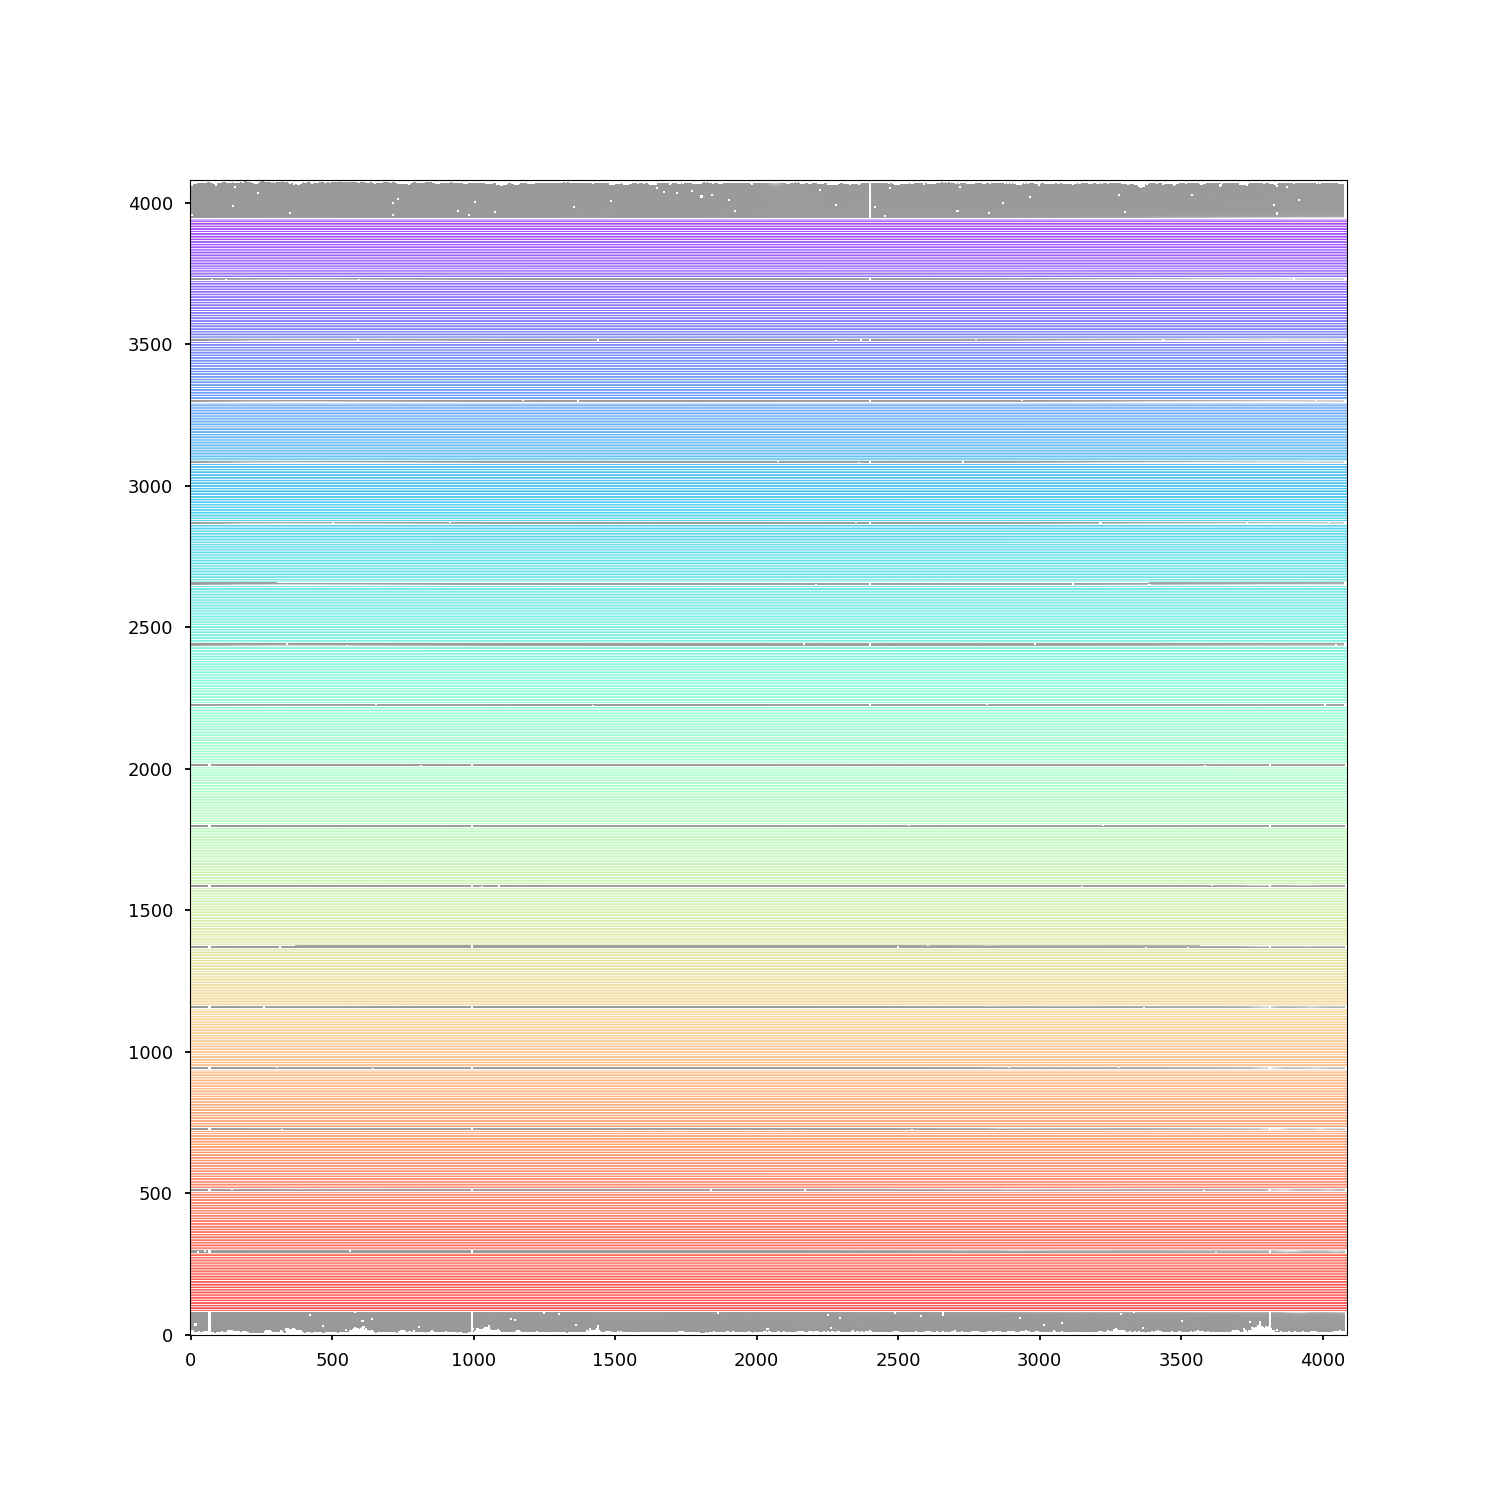

In [18]:
from lvmdrp.core import tracemask
from astropy.visualization import simple_norm

fig, ax = plt.subplots(figsize=(15,15))

trace = tracemask.TraceMask()
trace.loadFitsData(mtrace)

fiberflat = image.loadImage(mflat)
fiberflat.maskFiberTraces(trace, aperture=3)
fiberflat.apply_pixelmask()

fiberflat_data = fiberflat._data
# fiberflat_data[fiberflat._mask] = np.nan

norm = simple_norm(fiberflat_data, stretch="log", max_percent=95)
ax.imshow(fiberflat_data, norm=norm, origin="lower", cmap="binary_r")

for ifiber in range(trace._fibers):
    fiber = trace.getSpec(ifiber)
    ax.plot(fiber._pixels, fiber._data, color=plt.cm.rainbow(ifiber/trace._fibers), lw=0.5)

# ax.set_xlim(1950, 2050)
# ax.set_ylim(2900, 3100)

In [ ]:
# idx = -1
# print(masters_flat.iloc[idx].path)
# flat = image.loadImage(masters_flat.iloc[idx].path)

# yguess = flat.getSlitmap()["ypix"]

# profile = np.nan_to_num(flat._data[:, 2000], nan=0.0)
# ypix = np.arange(profile.size)

# # guess_heights = np.interp(yguess, ypix, profile)
# guess_heights = np.ones_like(yguess) * np.nanmax(profile)
# ref_profile = spectrum1d._spec_from_lines(yguess, sigma=1.2, wavelength=ypix, heights=guess_heights)

# plt.figure(figsize=(20,5))
# plt.step(ypix, ref_profile, lw=1, where="mid")
# plt.step(ypix, profile, lw=1, color="k", where="mid")
# plt.plot(yguess, np.ones_like(yguess) * np.nanmax(profile), ".", ms=5, color="red")

# plt.tight_layout()

# cc, bhat, mhat = spectrum1d._cross_match(ref_spec=ref_profile, obs_spec=profile, stretch_factors=np.linspace(0.7,1.3,5000), shift_range=[-100, 100])
# print(cc, bhat, mhat)

# plt.figure(figsize=(20,5))
# plt.step(ypix, spectrum1d._apply_shift_and_stretch(ref_profile, shift=bhat, stretch_factor=mhat), lw=0.5, color="b", where="mid")
# plt.step(ypix, profile, lw=1, color="k", where="mid")
# plt.plot(yguess*mhat + bhat, np.ones_like(yguess) * np.nanmax(profile), ".", ms=5, color="red")
# plt.tight_layout()

In [ ]:
for _, row in metadata.iterrows():
#     masters_cal = md.match_master_metadata(target_imagetyp=row.imagetyp, target_camera=row.camera)
#     bias, dark = masters_cal["bias"], masters_cal["dark"]
#     mbias_path = path.full("lvm_cal_mbias", drpver=drpver, tileid=bias.tileid, mjd=bias.mjd, camera=bias.camera)
#     mdark_path = path.full("lvm_cal_time", drpver=drpver, tileid=dark.tileid, mjd=dark.mjd, camera=dark.camera, exptime=dark.exptime, kind="mdark")
    
#     raw_path = path.full("lvm_raw", hemi="s", mjd=row.mjd, camspec=row.camera, expnum=row.expnum)
#     pre_path = path.full("lvm_anc", drpver=drpver, hemi="s", tileid=row.tileid, mjd=row.mjd, camera=row.camera, expnum=row.expnum, imagetype=row.imagetyp, kind="p")
    cal_path = path.full("lvm_master", drpver=drpver, tileid=row.tileid, mjd=row.mjd, camera=row.camera, kind="mflat")
    pks_path = path.full("lvm_cal", drpver=drpver, hemi="s", tileid=row.tileid, mjd=row.mjd, camera=row.camera, expnum=row.expnum, kind="peaks", ext="txt")
    
    # imageMethod.preproc_raw_frame(raw_path, pre_path)
    # imageMethod.detrend_frame(pre_path, cal_path)
    imageMethod.find_peaks_auto(cal_path, "peaks_test.fits", slice=2000, display_plots=True)

In [ ]:
cam = "b1"

input_fiberflat_path = f"/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/1111/60115/ancillary/lvm-cflat-{cam}-00000912.fits"
output_peaks_path = "peaks_test.fits"

imageMethod.find_peaks_auto(
    in_image=input_fiberflat_path, out_peaks=output_peaks_path,
    pixel_range=[10, 4000], fibers_dmin=5, threshold=0.08, slice=2000, median_box=[1, 10],
    display_plots=True)

imageMethod.trace_peaks(input_fiberflat_path, in_peaks=output_peaks_path, out_trace="trace_test.fits", poly_disp=6, threshold=20)

In [ ]:
x = fits.open("peaks_test.fits", ignore_missing_simple=True)
x[1].header

In [ ]:
_, obs_fibers, _, _ = np.genfromtxt(output_peaks_path, skip_header=1, dtype=[int, int, float, bool], unpack=True)

pixels = np.arange(4080)
obs_profile = np.zeros_like(pixels)
obs_profile[obs_fibers] = 1

plt.figure()
plt.hist(np.diff(obs_fibers), bins=50)
plt.gca().set_yscale("log")

In [ ]:
ref_sep = 5
ref_block = np.arange(0, ref_sep*36, ref_sep)
ref_block

ref_gap = 20
ref_dif = 125
nblocks = 18

ref_fibers = np.asarray([(ref_dif + i*(ref_block.max()+ref_gap)) + ref_block for i in range(nblocks)]).flatten()
ref_fibers

ref_profile = np.zeros_like(pixels)
ref_profile[ref_fibers] = 1

plt.figure(figsize=(15,5))
plt.step(pixels, ref_profile, lw=0.5, color="k", where="mid")
plt.step(pixels, obs_profile, lw=0.5, color="tab:blue", where="mid")


In [ ]:
# obs_profile = spectrum1d._apply_shift_and_stretch(ref_profile, shift=10, stretch_factor=0.9)
c, bhat, mhat = spectrum1d._cross_match(ref_profile, obs_profile, stretch_factors=np.linspace(0.8,1.2,2000), shift_range=[-100, 100], peak_num=648)
print(c, mhat, bhat)

plt.figure(figsize=(15,5))
plt.step(pixels, spectrum1d._apply_shift_and_stretch(ref_profile, shift=bhat, stretch_factor=mhat), lw=0.5, color="k", where="mid")
plt.step(pixels, obs_profile, lw=1, color="tab:red")

In [ ]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False).to_pandas()
frames_table = frames_table.loc[~frames_table.mjd.isin([60008,60009,60037,60038])]
# fix arc lamps metadata
fix_lamps_metadata(metadata=frames_table, lamp_names="argon neon ldls hgne xenon krypton".split())

# get master calibration metadata
masters_fiberflat = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="mfiberflat").sort_values("camera")

In [ ]:
for _, mfiberflat in masters_fiberflat.iterrows():
    print(mfiberflat)
    
    try:
        imageMethod.findPeaksAuto_drp(
            in_image=mfiberflat.path,
            out_peaks=out_calib_path.format(mjd=mfiberflat.mjd, kind="mpeaks", camera=mfiberflat.camera, exptime=mfiberflat.exptime).replace(".fits", ".txt"),
            nfibers=638, slice=3000, threshold=0, method="hyperbolic", median_box=10, median_cross=1, display_plots=1
        )
    except ValueError:
        imageMethod.image_logger.error(f"error while detecting fibers in '{mfiberflat.path}'")
        continue

In [ ]:
# avoid edges by one or two boxes before fitting the trace
for _, mfiberflat in masters_fiberflat.iterrows():
    print(mfiberflat)
    try:
        imageMethod.tracePeaks_drp(
            in_image=mfiberflat.path,
            out_trace=out_calib_path.format(mjd=mfiberflat.mjd, kind="mtrace", camera=mfiberflat.camera, exptime=int(mfiberflat.exptime) if mfiberflat.exptime != "x" else mfiberflat.exptime),
            in_peaks=out_calib_path.format(mjd=mfiberflat.mjd, kind="mpeaks", camera=mfiberflat.camera, exptime=int(mfiberflat.exptime) if mfiberflat.exptime != "x" else mfiberflat.exptime).replace(".fits", ".txt"),
            steps=30, coadd=1, threshold=0, max_diff=2, method="hyperbolic", median_box=10, median_cross=1, plot=1,
            poly_disp=2
        )
    except np.linalg.LinAlgError:
        imageMethod.image_logger.error(f"error while tracing fiberflat '{mfiberflat.path}'")
        continue

In [ ]:
# from lvmdrp.core import tracemask
# from astropy.visualization import simple_norm

# trace_path = out_calib_path.format(mjd="super", kind="mtrace", camera="r2", exptime="x")

# trace = tracemask.TraceMask()
# trace.loadFitsData(trace_path)

# fiberflat = image.loadImage(trace_path.replace("mtrace", "mfiberflat"))

# fiberflat_data = fiberflat._data
# # fiberflat_data[fiberflat._mask] = np.nan

# norm = simple_norm(fiberflat_data, stretch="log", max_percent=95)
# fig, ax = plt.subplots(figsize=(10,10))
# ax.imshow(fiberflat_data, norm=norm, origin="lower", cmap="binary_r")

# for ifiber in range(trace._fibers):
#     fiber = trace.getSpec(ifiber)
#     ax.plot(fiber._pixels, fiber._data, color=plt.cm.rainbow(ifiber/trace._fibers), lw=1)

In [ ]:
# trace._pixels[[0,-1]]

In [ ]:
# peaks = np.loadtxt("data/lvm-super-mpeaks-r2-x.txt", skiprows=1)
# peaks

In [ ]:
# plt.figure(figsize=(20,5))
# plt.plot(peaks[:,2], np.zeros_like(peaks[:,0]), ".")

In [ ]:
# from np.polynomial import Polynomial

# # poly = Polynomial(trace._coeffs[0], domain=trace._pixels[[0-1]].tolist())

# # poly(trace._pixels), trace._data

# plt.figure(figsize=(20,5))

# icoef = 0
# mlinear = Polynomial.fit(peaks[:,2], trace._coeffs[:, icoef], deg=1)
# plt.plot(peaks[:,2], trace._coeffs[:, icoef] - peaks[:,2], ".")


In [ ]:
master_traces = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="mtrace", exptime="x")
print(master_traces.to_string())

for _, mfiberflat in masters_fiberflat.iterrows():
    print(mfiberflat)
    master_trace = master_traces.query("camera==@mfiberflat.camera")
    try:
        mtrace = master_trace.iloc[0]
    except:
        imageMethod.image_logger.error(f"no master trace found for '{mfiberflat.path}'")
        continue
    
    imageMethod.extractSpec_drp(
        in_image=mfiberflat.path,
        out_rss=out_calib_path.format(mjd=mfiberflat.mjd, kind="xfiberflat", camera=mfiberflat.camera, exptime=int(mfiberflat.exptime) if mfiberflat.exptime != "x" else mfiberflat.exptime),
        in_trace=mtrace.path,
        method="aperture", aperture=4, plot=1, parallel="auto"
    )